In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats

from google.colab import drive
drive.mount('/content/drive')
import os
PATH = '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator'
os.chdir(PATH)
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Parallel_PDE_project/fourier_neural_operator/Notebooks')


Mounted at /content/drive


In [2]:
from utils import *
from Adam import * 
# from FNO import FNO

In [44]:
###### FNO.py
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

########################################################################
torch.manual_seed(0)
np.random.seed(0)

################################################################
# Spectral Convolution Layers 
# 1D and 2D
################################################################

class fourier_conv_1d(nn.Module):
  def __init__(self, in_, out_, wavenumber1):
    super(fourier_conv_1d, self).__init__()
    self.in_ = in_
    self.out_ = out_
    self.wavenumber1 = wavenumber1
    self.scale = (1 / (in_ * out_))
    self.weights1 = nn.Parameter(self.scale * torch.rand(in_, out_, self.wavenumber1, dtype=torch.cfloat))
   
    # Complex multiplication
  def compl_mul1d(self, input, weights):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    return torch.einsum("bix,iox->box", input, weights)

  def forward(self, x):
    batchsize = x.shape[0]
    #Compute Fourier coeffcients up to factor of e^(- something constant)
    x_ft = torch.fft.rfft(x)

    # Multiply relevant Fourier modes
    out_ft = torch.zeros(batchsize, self.out_, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
    out_ft[:, :, :self.wavenumber1] = self.compl_mul1d(x_ft[:, :, :self.wavenumber1], self.weights1)

    #Return to physical space
    x = torch.fft.irfft(out_ft, n=x.size(-1))
    return x

  def print(self):
    return f'FourierConv1d({self.in_}, {self.out_}, wavenumber={self.wavenumber1})'

class fourier_conv_2d(nn.Module):
  def __init__(self, in_, out_, wavenumber1, wavenumber2):
    super(fourier_conv_2d, self).__init__()
    self.in_ = in_
    self.out_ = out_
    self.wavenumber1 = wavenumber1
    self.wavenumber2 = wavenumber2
    self.scale = (1 / (in_ * out_))
    self.weights1 = nn.Parameter(self.scale * torch.rand(in_, out_, self.wavenumber1, self.wavenumber2, dtype=torch.cfloat))
    self.weights2 = nn.Parameter(self.scale * torch.rand(in_, out_, self.wavenumber1, self.wavenumber2, dtype=torch.cfloat))

    # Complex multiplication
  def compl_mul2d(self, input, weights):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    return torch.einsum("bixy,ioxy->boxy", input, weights)

  def forward(self, x):
    batchsize = x.shape[0]
    #Compute Fourier coeffcients up to factor of e^(- something constant)
    x_ft = torch.fft.rfft2(x)
    # Multiply relevant Fourier modes
    out_ft = torch.zeros(batchsize, self.in_,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
    out_ft[:, :, :self.wavenumber1, :self.wavenumber2] = \
        self.compl_mul2d(x_ft[:, :, :self.wavenumber1, :self.wavenumber2], self.weights1)
    out_ft[:, :, -self.wavenumber1:, :self.wavenumber2] = \
        self.compl_mul2d(x_ft[:, :, -self.wavenumber1:, :self.wavenumber2], self.weights2)
    #Return to physical space
    x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
    return x

  def print(self):
    return f'FourierConv2d({self.in_}, {self.out_}, wavenumber={self.wavenumber1, self.wavenumber2})'

################################################################
# Fourier Layer 
################################################################
class Fourier_layer(nn.Module):
  def __init__(self,  features_, wavenumber, activation = 'relu', is_last = False):
    super(Fourier_layer, self).__init__()
    self.is_last = is_last
    self.activation = activation.lower()
    self.features_ = features_
    self.wavenumber = wavenumber
    self.dim = len(wavenumber)
    self.W =  nn.Conv1d(features_, features_, 1) if self.dim==1 else nn.Conv2d(features_, features_, 1)
    self.fourier_conv = self.set_conv_dim()
    self.nonlinear = set_activ(activation)

  def set_conv_dim(self):
    if self.dim== 1:
      return  fourier_conv_1d(self.features_, self.features_, *self.wavenumber)
    elif self.dim== 2:
      return  fourier_conv_2d(self.features_, self.features_, *self.wavenumber)
   
  def forward(self, x):
        x = self.fourier_conv(x)
        if self.is_last == True:
          return x
        else:
          x = self.nonlinear(x)
          return x
            
  def print(self):
    return self.activation+'(' + self.fourier_conv.print() + ')'


################################################################
# NN_layer Layer 
################################################################
class NN_layer(nn.Module):
  def __init__(self,  features_, wavenumber, activation = 'relu', is_last = False):
    super(NN_layer, self).__init__()
    self.is_last = is_last
    self.activation = activation.lower()
    self.features_ = features_
    self.dim = len(wavenumber)
    self.W =  nn.Conv1d(features_, features_, 1) if self.dim==1 else nn.Conv2d(features_, features_, 1)
    self.nonlinear = set_activ(activation)
    # self.dropout = nn.Dropout(0.8)

  def forward(self, x):
        x = self.W(x)
        # x = self.dropout(x)
        if self.is_last == True:
          return x
        else:
          x = self.nonlinear(x)
          return x
            
  def print(self):
    return self.activation+'('+ self.W.__repr__() + ')'

################################################################
# SM layer = Fourier layer + NN layer
################################################################
class SMLayer(nn.Module):
  def __init__(self, features_, wavenumber, activation = 'relu', is_last = False, rate = -1):
    super(SMLayer, self).__init__()
    self.F_layer = Fourier_layer(features_, wavenumber, activation, is_last)
    self.N_layer = NN_layer(features_, wavenumber, activation, is_last)
    self.rate = rate

  def freeze_layer(self, n):
    if(n == 0):
      for param in self.N_layer.parameters():
          param.requires_grad = False
      for param in self.F_layer.parameters():
          param.requires_grad = True
    elif(n == 1):
      for param in self.N_layer.parameters():
          param.requires_grad = True
      for param in self.F_layer.parameters():
          param.requires_grad = False
    elif(n == -1):
      for param in self.N_layer.parameters():
          param.requires_grad = False
      for param in self.F_layer.parameters():
          param.requires_grad = False
    else:
      for param in self.N_layer.parameters():
          param.requires_grad = True
      for param in self.F_layer.parameters():
          param.requires_grad = True

  def forward(self, x):
    if(self.rate == -1):
      return self.F_layer.forward(x) + self.N_layer.forward(x)
    else:
      num = np.random.binomial(1, self.rate)
      if(num == 1):
        self.freeze_layer(1)
        return self.N_layer.forward(x)
      else:
        self.freeze_layer(0)
        return self.F_layer.forward(x)

  
  # def backward(self, x):
  #   if(self.rate == 1):
  #     return self.F_layer.backward(x) + self.N_layer.backward(x)
  #   else:
  #     if(self.num == 1):
  #       return self.N_layer.backward(x)
  #     else:
  #       return self.F_layer.backward(x)

  def __repr__(self):
    with torch.no_grad():
      return "Split model rate: "+ str(self.rate) + " " + self.N_layer.print() + " + " + self.F_layer.print()


################################################################
# FM layer = Fourier layer + NN layer tained separately
################################################################
class FMLayer(nn.Module):
  def __init__(self, features_, wavenumber, activation = 'relu', is_last = False, epochs = 0):
    super(FMLayer, self).__init__()
    self.F_layer = Fourier_layer(features_, wavenumber, activation, is_last)
    self.N_layer = NN_layer(features_, wavenumber, activation, is_last)
    self.count = epochs
    self.epochs = epochs

  def freeze_layer(self, n):
    if(n == 0):
      for param in self.N_layer.parameters():
          param.requires_grad = False
      for param in self.F_layer.parameters():
          param.requires_grad = True
    elif(n == 1):
      for param in self.N_layer.parameters():
          param.requires_grad = True
      for param in self.F_layer.parameters():
          param.requires_grad = False
    elif(n == -1):
      for param in self.N_layer.parameters():
          param.requires_grad = False
      for param in self.F_layer.parameters():
          param.requires_grad = False
    else:
      for param in self.N_layer.parameters():
          param.requires_grad = True
      for param in self.F_layer.parameters():
          param.requires_grad = True

  def forward(self, x):
    if( self.count != 0):
      if(self.count + 1  > self.epochs // 2):
        
        self.freeze_layer(0)
        return self.F_layer.forward(x)
      else:
        self.freeze_layer(1)
        return self.N_layer.forward(x)
        
    else:
      # self.freeze_layer(-1)
      return self.N_layer.forward(x) + self.F_layer.forward(x)

  # def backward(self,x):
  #   if(self.count + 1  > self.epochs // 2):
  #         return self.N_layer.backward(x)
  #   else:
  #     return self.F_layer.backward(x)
            
  def __repr__(self):
    with torch.no_grad():
      return "Frozen model "+ self.N_layer.print() + " and " + self.F_layer.print()



################################################################
# Lifting map
################################################################

class R(nn.Module):
  def __init__(self, input, width, activation = 'relu'):
    super().__init__()
    self.fc1 = nn.Linear(input, width)
    # self.nonlinear =set_activ(activation)
    # self.fc2 = nn.Linear(width//2, width)
  def forward(self,x):
    x = self.fc1(x)
    # x = self.nonlinear(x)
    # x = self.fc2(x)
    return x

################################################################
# Projection map
################################################################

class P(nn.Module):
  def __init__(self, width1, width2):
    super().__init__()
    self.fc1 = nn.Linear(width1, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, width2)
    self.nonlinear =torch.nn.functional.relu
  def forward(self,x):
    x = self.fc1(x)
    x = self.nonlinear(x)
    x = self.fc2(x)
    x = self.nonlinear(x)
    x = self.fc3(x)
    return x


################################################################
# FNO map 1D and 2D
################################################################
class FNO(nn.Module):
  def __init__(self, wavenumber, features_, layers, 
                    padding = 9, 
                    activation= 'relu',
                    lifting = None, 
                    proj = None,
                    rate = -1,
                    epochs = 0):
    super(FNO, self).__init__()
    self.wavenumber = wavenumber
    self.dim = len(wavenumber)
    self.activation = activation.lower() 
    self.padding = padding   
    self.features_ =features_
    self.layers = layers
    self.lifting = lifting(self.dim+1, self.features_)
    self.fno = []
    self.proj = proj(self.features_, 1)
    
    for l in range(layers-1):
      self.fno.append(SMLayer(features_ = self.features_, 
                                    wavenumber=self.wavenumber, 
                                    activation = self.activation,
                                    rate = rate))
      
    self.fno.append(SMLayer(features_=self.features_, 
                                    wavenumber=self.wavenumber, 
                                    activation = self.activation,
                                    is_last= True,
                                    rate = rate))
    self.fno =nn.Sequential(*self.fno)

  def forward(self, x):
    grid = self.get_grid2D(x.shape, x.device) if self.dim == 2 else self.get_grid1D(x.shape, x.device)
    x = torch.cat((x, grid), dim=-1)
    ####Lifting Map 
    x = self.lifting(x)
    ###Actual Neural Operator
    x = x.permute(0, 3, 1, 2) if self.dim == 2 else x.permute(0, 2, 1)
    x = F.pad(x, [0,self.padding, 0,self.padding]) if self.dim == 2 else F.pad(x, [0,self.padding])
    x = self.fno(x)
    x = x[..., :-self.padding, :-self.padding] if self.dim == 2 else x[..., :-self.padding]
    x = x.permute(0, 2, 3, 1) if self.dim == 2 else x.permute(0, 2, 1)
    ####Projection Map
    x =self.proj(x)
    return x
    
  def get_grid2D(self, shape, device):
    batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    return torch.cat((gridx, gridy), dim=-1).to(device)

  def get_grid1D(self, shape, device):
    batchsize, size_x = shape[0], shape[1]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
    return gridx.to(device)

  def count(self):
    for i in self.fno:
      i.count -= 1
  
  def change_rate(self, r):
    for i in self.fno:
      i.rate = r

################################################################
# Miscellaneous
################################################################

def set_activ(activation):
  with torch.no_grad():
    if activation == 'relu':
      nonlinear = F.relu
    elif activation == 'tanh':
      nonlinear = nn.Tanh()
    elif activation == 'sine':
      nonlinear= torch.sin
    elif activation == 'gelu':
      nonlinear= F.gelu
    elif activation == None:
      nonlinear = lambda a : a
    else:
      raise Exception('The activation is not recognized from the list')
    return nonlinear

##########################################################

In [4]:
################################################################
# load data and data normalization
################################################################
EqFile = 'DarcyFlow'
PDE_dir =  os.path.join(PATH, 'data', EqFile)
x_train = torch.load( os.path.join(PDE_dir, f'{EqFile}_x_train.pt'))
y_train = torch.load(os.path.join(PDE_dir, f'{EqFile}_y_train.pt'))
x_test = torch.load(os.path.join(PDE_dir, f'{EqFile}_x_test.pt'))
y_test= torch.load(os.path.join(PDE_dir, f'{EqFile}_y_test.pt'))
#Parameters
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
s = x_test.shape[-2]
batch_size = 10
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s,s,1)
#x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,s,1)
#x_test = x_test.reshape(ntest,s,1)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [45]:


#NN parameters
activ_vec = ['relu', 'tanh', 'sine', 'gelu']
learning_rate = 0.001
activ = activ_vec[0]
epochs = 100
step_size = epochs//10
gamma = 0.5

wavenumber = [20, 20]
features_ = 32

In [46]:
torch.manual_seed(0)
model = FNO(wavenumber = wavenumber,
            features_ =features_, 
            activation = activ,
            layers =4, 
            lifting = R,
            proj = P,
            rate = -1,
            epochs = epochs).to(device)
model

FNO(
  (lifting): R(
    (fc1): Linear(in_features=3, out_features=32, bias=True)
  )
  (proj): P(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
  )
  (fno): Sequential(
    (0): Split model rate: -1 relu(Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))) + relu(FourierConv2d(32, 32, wavenumber=(20, 20)))
    (1): Split model rate: -1 relu(Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))) + relu(FourierConv2d(32, 32, wavenumber=(20, 20)))
    (2): Split model rate: -1 relu(Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))) + relu(FourierConv2d(32, 32, wavenumber=(20, 20)))
    (3): Split model rate: -1 relu(Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))) + relu(FourierConv2d(32, 32, wavenumber=(20, 20)))
  )
)

In [47]:
loss_train = []
loss_test =  []
epoch_vec = []
filename = f'FNO_problem_{EqFile}_epoch_{epochs}_wavenumber_{wavenumber}_features_{features_}_act_{activ}'
filename
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = LpLoss(size_average=False)
y_normalizer.to(device)

################################################################
# training and evaluation

# distribution = np.random.binomial(len(test_loader), 0.5, epochs)/len(test_loader)
distribution = np.random.normal(len(test_loader)//2, 1, epochs)/len(test_loader)

for ep in range(epochs):

    model.change_rate(distribution[ep])

    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        #out = model(x).reshape(batch_size, s)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    # model.count()
    #check weight
    # print("F", model.fno[0].F_layer.fourier_conv.weights1.data[0][6][0])
    # print("N", model.fno[0].N_layer.W.weight.data[0][6])

    epoch_vec.append(ep)
    #e= epoch_vec[-1]
    #epoch_vec.append(e+1)
    
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
    
            out = model(x).reshape(batch_size, s, s)
            #out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    loss_train.append(train_l2)
    loss_test.append(test_l2)

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)

3291713
0 1.7295534490003774 0.2112103511095047 0.1410700786113739
1 1.827251788000467 0.1280361096262932 0.12208130896091461
2 1.8618914129992845 0.12374489343166352 0.12397059082984924
3 1.8224115030006942 0.1293583083152771 0.13601733803749083
4 1.7971311319997767 0.12445717889070511 0.11526816368103027
5 2.0618431150005563 0.10683806109428405 0.10526183664798737
6 1.8812145820002115 0.11248946231603622 0.11734408974647521
7 2.089749801000835 0.10181359493732453 0.09833844721317292
8 2.088428336999641 0.09596313112974167 0.09003081619739532
9 1.9264420030003748 0.09492419391870499 0.10326429724693298
10 1.9086901840000792 0.09572426259517669 0.0929071319103241
11 1.8032720829996833 0.10048949253559113 0.11197017669677735
12 1.9014025110000148 0.08306299841403961 0.10888565897941589
13 1.9176583660000688 0.08251239889860153 0.07845071256160736
14 1.996896624999863 0.0817501030266285 0.07657508671283722
15 1.9849826899999243 0.07393269211053849 0.07100697696208953
16 1.814398868999887

In [48]:
print(f'saving model at epoch {ep}')
file_path = os.path.join(PATH, 'trained_models')
torch.save(model, os.path.join(file_path, filename+'_split_normal.plt'))

saving model at epoch 99


0.054426702529191975


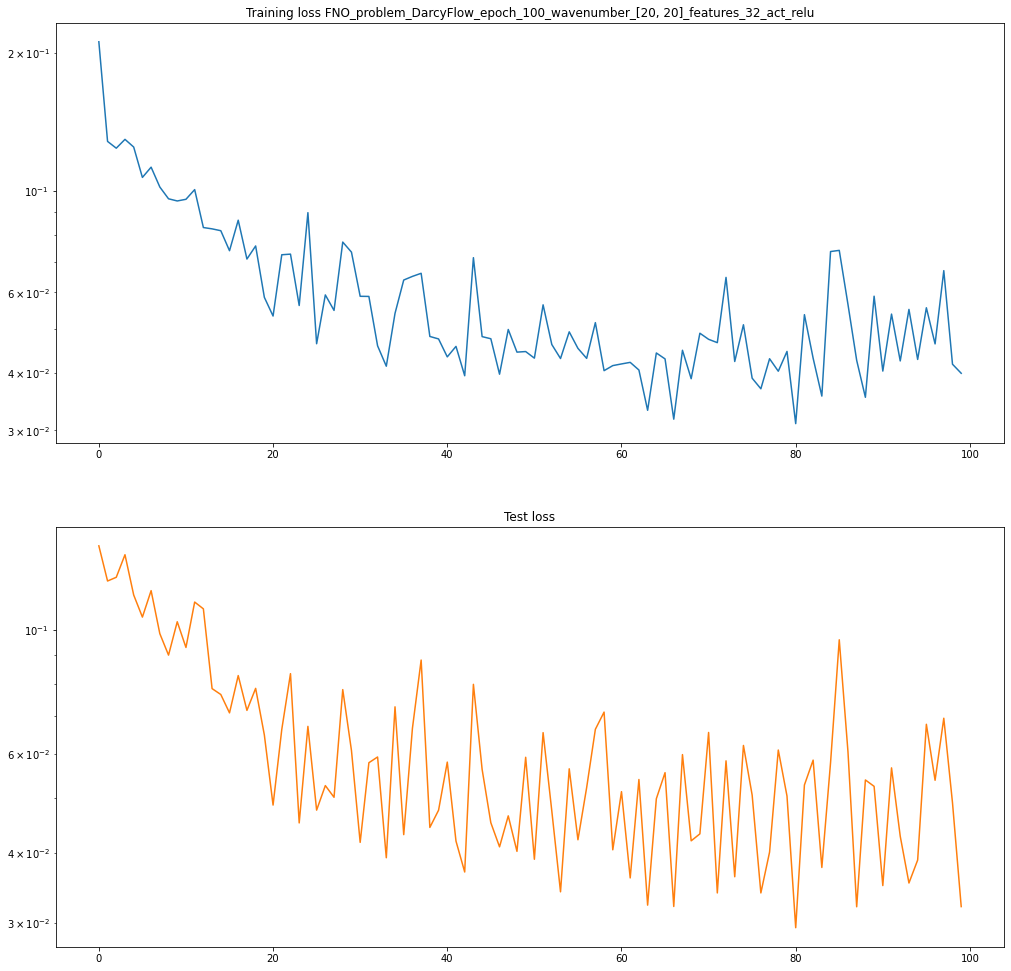

In [49]:
  fig, axs = plt.subplots(2, 1, figsize=(17,17))
  axs[0].plot(epoch_vec, loss_train)
  axs[0].set_title(f'Training loss {filename}')
  axs[0].set_yscale('log')
  axs[1].plot(epoch_vec, loss_test, 'tab:orange')
  axs[1].set_title('Test loss')
  axs[1].set_yscale('log')
  plt.savefig(os.path.join(PATH, 'figures', filename+'_split_normal.png'))
  print(sum(loss_test[-5:])/5)

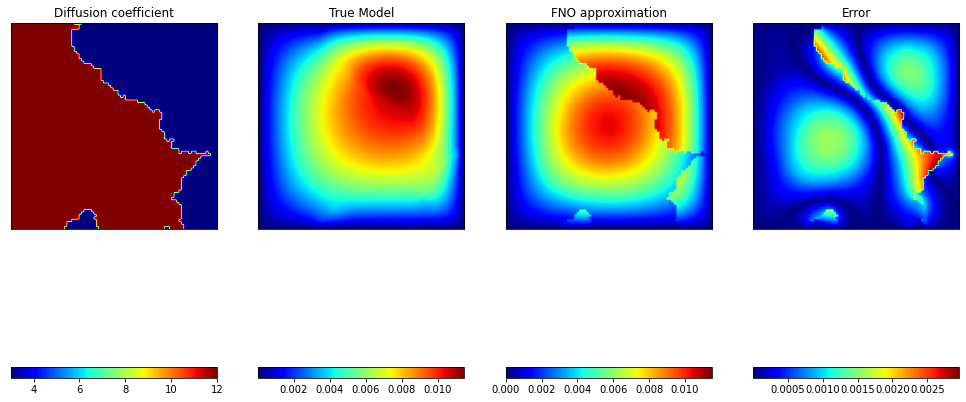

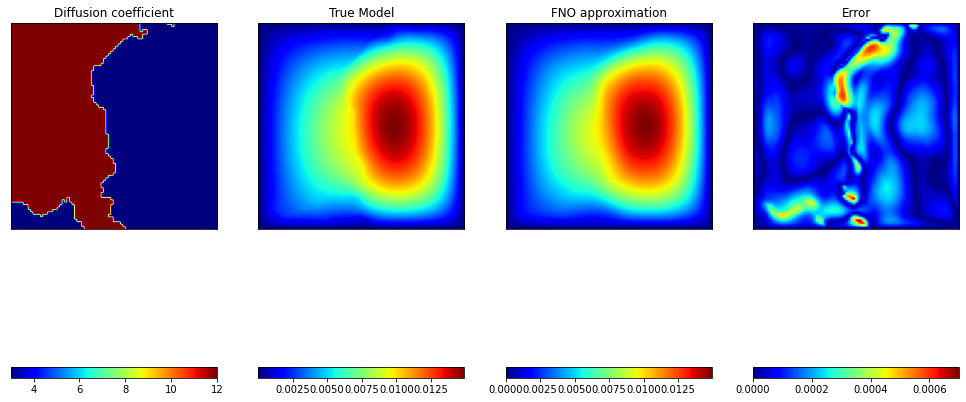

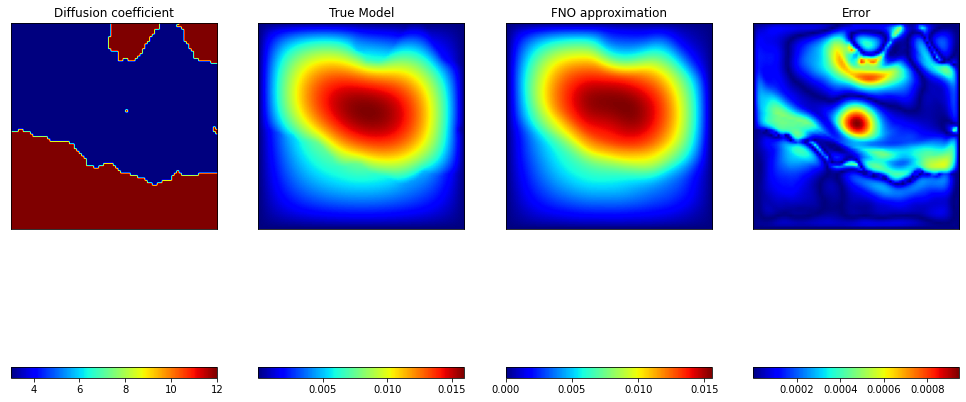

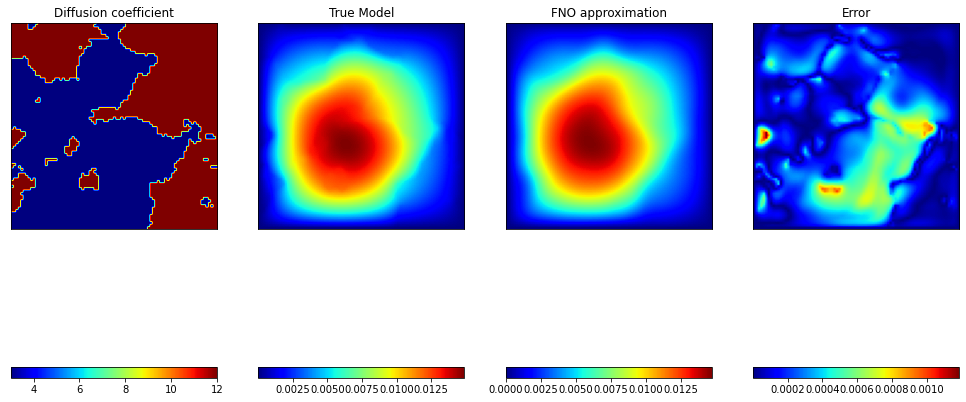

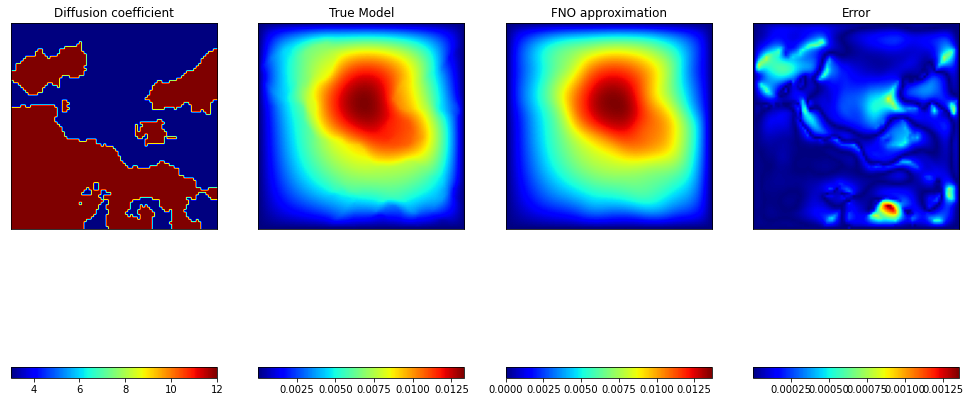

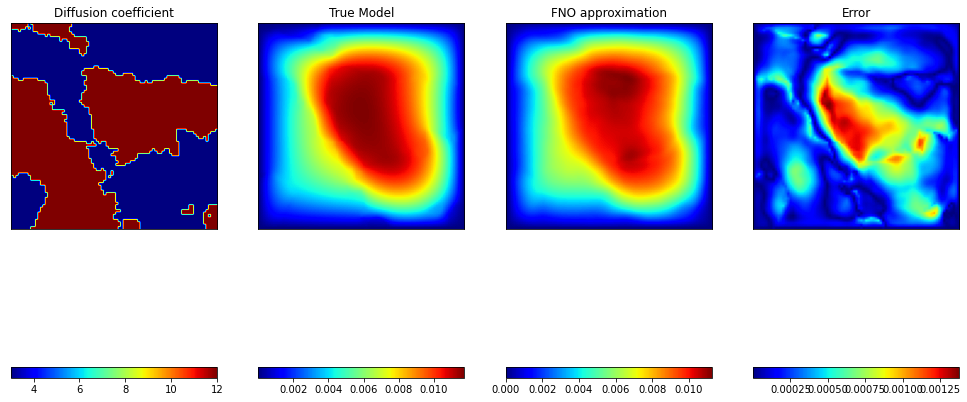

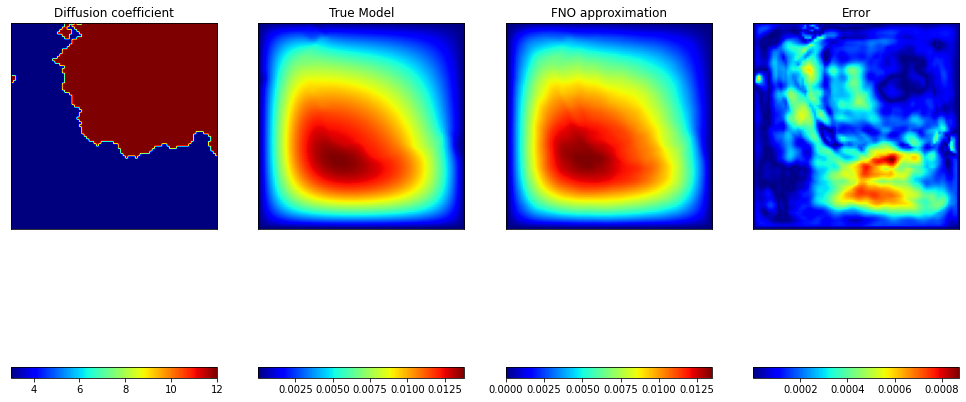

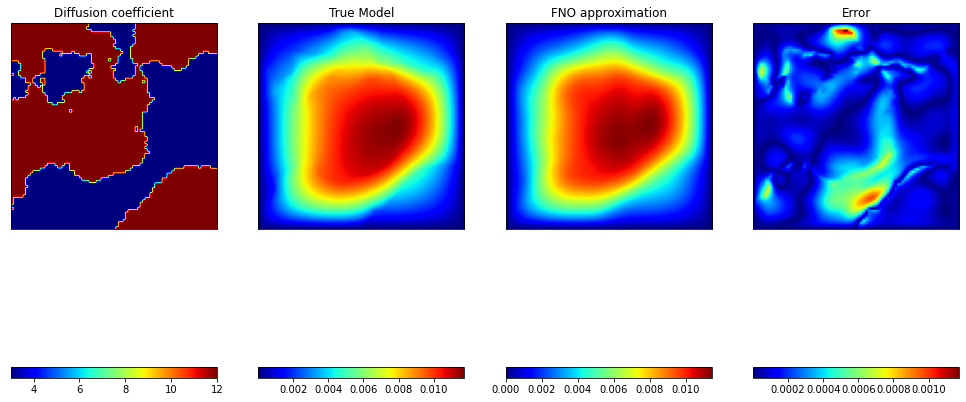

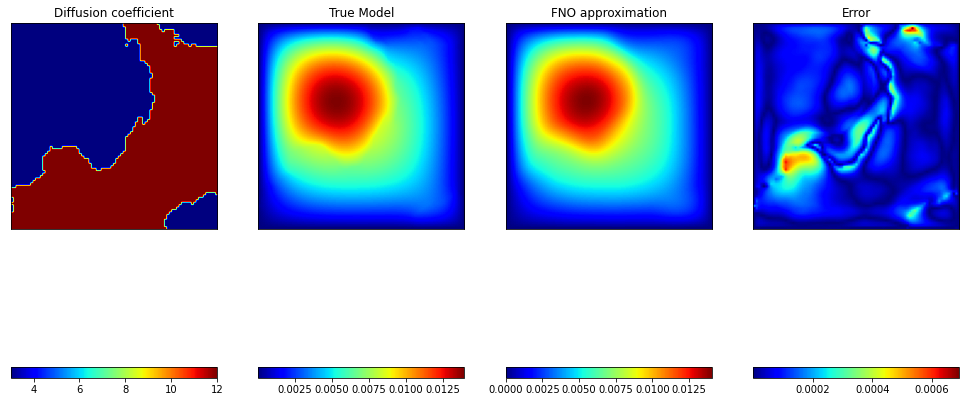

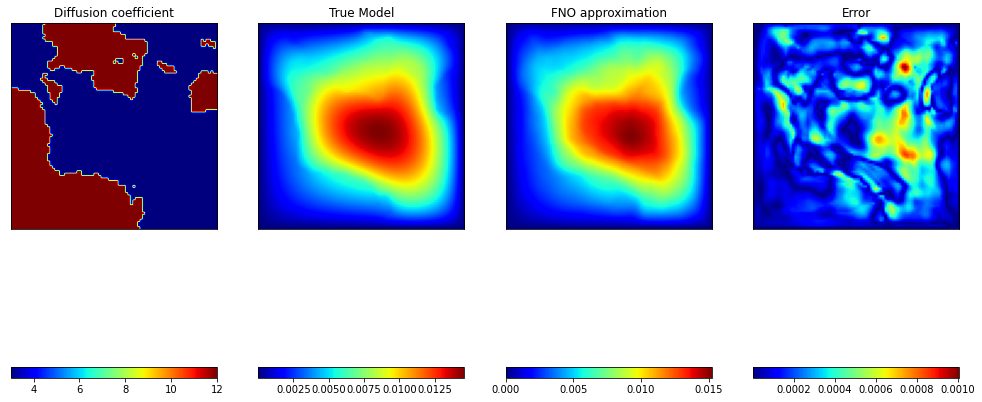

0.0450457651168108


In [51]:
import numpy as np
import matplotlib.pyplot as plt

import torch
filename = f'FNO_problem_{EqFile}_epoch_{epochs}_wavenumber_{wavenumber}_features_{features_}_act_{activ}'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_= FNO(wavenumber = wavenumber,
            features_ =features_, 
            activation = activ,
            layers =4, 
            lifting = R,
            proj = P)
model_ = torch.load(os.path.join('trained_models',filename+'_split_normal.plt'), map_location=torch.device('cpu'))

################################################################
# load data and data normalization
################################################################
EqFile = 'DarcyFlow'
PDE_dir =  os.path.join(PATH, 'data', EqFile)
x_train = torch.load( os.path.join(PDE_dir, f'{EqFile}_x_train.pt'))
y_train = torch.load(os.path.join(PDE_dir, f'{EqFile}_y_train.pt'))
x_test = torch.load(os.path.join(PDE_dir, f'{EqFile}_x_test.pt'))
y_test= torch.load(os.path.join(PDE_dir, f'{EqFile}_y_test.pt'))

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,s,s,1)
x_test = x_test.reshape(ntest,s,s,1)

np.random.seed(1)
n_values = np.random.randint(low = 0, high = 100, size = 10)
n_values
loss = 0
for n in n_values: 
    y = model_(x_test[n,...].view(1,s,s,1))
    y_decode_rec = y_normalizer.decode(y.view(1,s,s))
    X_decode_test= x_normalizer.decode(x_test[n,...].view(1,s,s))
    y_true_decode = y_test[n,...].view(1,s,s)

    plt.figure(figsize=(17,17))
    cmap = 'jet'

    plt.subplot(1,4,1)
    plt.imshow(X_decode_test.view(s,s).detach().numpy(), cmap =cmap)
    plt.title('Diffusion coefficient')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(orientation="horizontal")


    plt.subplot(1,4,2)
    plt.imshow(y_true_decode.reshape(s,s).detach().numpy(), cmap = cmap)
    plt.title('True Model')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(orientation="horizontal")


    plt.subplot(1,4,3)
    plt.imshow(y_decode_rec.view(s,s).detach().numpy(), cmap = cmap)
    plt.title('FNO approximation')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(orientation="horizontal")


    plt.subplot(1,4,4)
    plt.imshow((y_decode_rec-y_true_decode).view(s,s).abs().detach().numpy(), cmap = cmap)
    plt.title('Error')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(orientation="horizontal")
    plt.savefig(os.path.join(PATH, 'figures', 'test', f'ex_{n}_'+filename+'_split_normal.png'))
    plt.show();

    myloss = LpLoss()
    loss += myloss(y_decode_rec, y_true_decode).item()
print(loss/10)


In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))



layer = 1
filter = model_.features[layer].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

NameError: ignored